<a href="https://colab.research.google.com/github/b21renu/DeepFakes/blob/main/DeepVoiceAI_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Print dataset structure
print(f"Dataset path: {birdy654_deep_voice_deepfake_voice_recognition_path}")
print("\nContents of dataset directory:")
for root, dirs, files in os.walk(birdy654_deep_voice_deepfake_voice_recognition_path):
    print(f"\nDirectory: {root}")
    if dirs:
        print(f"Subdirectories: {dirs}")
    if files:
        print(f"Number of files: {len(files)}")
        print(f"Sample files: {files[:5]}")

Dataset path: /root/.cache/kagglehub/datasets/birdy654/deep-voice-deepfake-voice-recognition/versions/2

Contents of dataset directory:

Directory: /root/.cache/kagglehub/datasets/birdy654/deep-voice-deepfake-voice-recognition/versions/2
Subdirectories: ['DEMONSTRATION', 'KAGGLE']

Directory: /root/.cache/kagglehub/datasets/birdy654/deep-voice-deepfake-voice-recognition/versions/2/DEMONSTRATION
Subdirectories: ['DEMONSTRATION']

Directory: /root/.cache/kagglehub/datasets/birdy654/deep-voice-deepfake-voice-recognition/versions/2/DEMONSTRATION/DEMONSTRATION
Number of files: 2
Sample files: ['linus-to-musk-DEMO.mp3', 'linus-original-DEMO.mp3']

Directory: /root/.cache/kagglehub/datasets/birdy654/deep-voice-deepfake-voice-recognition/versions/2/KAGGLE
Subdirectories: ['AUDIO']
Number of files: 1
Sample files: ['DATASET-balanced.csv']

Directory: /root/.cache/kagglehub/datasets/birdy654/deep-voice-deepfake-voice-recognition/versions/2/KAGGLE/AUDIO
Subdirectories: ['REAL', 'FAKE']

Directory

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
birdy654_deep_voice_deepfake_voice_recognition_path = kagglehub.dataset_download('birdy654/deep-voice-deepfake-voice-recognition')

print('Data source import complete.')


Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install librosa
!pip install pydub

In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
from pydub import AudioSegment
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
import random
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

# Update the dataset_path to the correct location of your data
dataset_path = "/content/drive/My Drive/ProfElective_GenAI/archive/KAGGLE/AUDIO" # Changed from KAGGLE/AUDIO to LA
augmented_dataset_path = "/kaggle/working/LA/SPLITTED" # Changed from KAGGLE/SPLITTED to LA/SPLITTED


# Create directories for audio data
os.makedirs(augmented_dataset_path, exist_ok=True)
os.makedirs(os.path.join(augmented_dataset_path, "FAKE"), exist_ok=True)
os.makedirs(os.path.join(augmented_dataset_path, "REAL"), exist_ok=True)



In [ ]:
# Count the number of original audio files
# Updated path to include the 'LA' folder:
# Removed extra 'LA' from the path
real_original_count = birdy654_deep_voice_deepfake_voice_recognition_path
fake_original_count = birdy654_deep_voice_deepfake_voice_recognition_path

# Count the number of 10-second segments after splitting
# Updated path to include the 'LA' folder:
real_segments_count = len(os.listdir(os.path.join(augmented_dataset_path, "REAL")))
fake_segments_count = len(os.listdir(os.path.join(augmented_dataset_path, "FAKE")))  # Assuming 'SELECTED_FAKE' is the correct folder

# Print the counts
print(f"Original REAL audio files: {real_original_count}")
print(f"Original FAKE audio files: {fake_original_count}")
print(f"10-second REAL audio segments: {real_segments_count}")
print(f"10-second FAKE audio segments: {fake_segments_count}")

Original REAL audio files: /root/.cache/kagglehub/datasets/birdy654/deep-voice-deepfake-voice-recognition/versions/2
Original FAKE audio files: /root/.cache/kagglehub/datasets/birdy654/deep-voice-deepfake-voice-recognition/versions/2
10-second REAL audio segments: 0
10-second FAKE audio segments: 0


In [ ]:
# Define max_pad_len to ensure consistent feature length
max_pad_len = 862  # Ensure this is the same length used in the extract_features function

# Function to extract features using MFCC, Chroma, Spectral Contrast, and Tonnetz
def extract_features(file_path, n_mfcc=13, n_fft=2048, hop_length=512, max_pad_len=862):
    y, sr = librosa.load(file_path, sr=None)
    stft = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(stft), sr=sr, n_mfcc=n_mfcc)
    chroma = librosa.feature.chroma_stft(S=librosa.power_to_db(stft), sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(S=librosa.power_to_db(stft), sr=sr)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

    # Pad or truncate the features
    if mfccs.shape[1] > max_pad_len:
        mfccs = mfccs[:, :max_pad_len]
    else:
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    if chroma.shape[1] > max_pad_len:
        chroma = chroma[:, :max_pad_len]
    else:
        pad_width = max_pad_len - chroma.shape[1]
        chroma = np.pad(chroma, pad_width=((0, 0), (0, pad_width)), mode='constant')

    if spectral_contrast.shape[1] > max_pad_len:
        spectral_contrast = spectral_contrast[:, :max_pad_len]
    else:
        pad_width = max_pad_len - spectral_contrast.shape[1]
        spectral_contrast = np.pad(spectral_contrast, pad_width=((0, 0), (0, pad_width)), mode='constant')

    if tonnetz.shape[1] > max_pad_len:
        tonnetz = tonnetz[:, :max_pad_len]
    else:
        pad_width = max_pad_len - tonnetz.shape[1]
        tonnetz = np.pad(tonnetz, pad_width=((0, 0), (0, pad_width)), mode='constant')

    return np.concatenate((mfccs, chroma, spectral_contrast, tonnetz), axis=0).T

# Function to build an enhanced LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, input_shape=input_shape, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Preprocess the data
def load_and_extract_features(base_path, label, max_pad_len=862):
    features = []
    labels = []
    for file_name in tqdm(os.listdir(base_path), desc=f"Extracting features from {label} audio files"):
        file_path = os.path.join(base_path, file_name)
        if file_path.endswith('.wav'):
            features.append(extract_features(file_path, max_pad_len=max_pad_len))
            labels.append(label)
    return features, labels

In [ ]:
# Define max_pad_len
max_pad_len = 862  # Ensure this is the same length used in the extract_features function

# Paths for the extracted features
# Updated paths to match the augmented_dataset_path defined earlier:
fake_samples_path = os.path.join(augmented_dataset_path, "FAKE")
real_samples_path = os.path.join(augmented_dataset_path, "REAL")

# Extract features for fake and real samples
fake_features, fake_labels = load_and_extract_features(fake_samples_path, "FAKE", max_pad_len=max_pad_len)
real_features, real_labels = load_and_extract_features(real_samples_path, "REAL", max_pad_len=max_pad_len)

Extracting features from FAKE audio files: 0it [00:00, ?it/s]
Extracting features from REAL audio files: 0it [00:00, ?it/s]


In [ ]:
import os
import numpy as np
import librosa
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def load_audio_file(file_path, sr=22050):
    """
    Load an audio file with proper error handling and conversion if needed.
    """
    try:
        # First try loading directly with librosa
        audio, sr = librosa.load(file_path, sr=sr)
        return audio, sr
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None, None

def extract_features(audio, sr, max_pad_len=862):
    """
    Extract MFCC features from loaded audio data.
    """
    try:
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

        # Transpose to get time steps as the first dimension
        mfccs = mfccs.T

        # Pad or truncate to max_pad_len
        if mfccs.shape[0] < max_pad_len:
            pad_width = max_pad_len - mfccs.shape[0]
            mfccs = np.pad(mfccs, ((0, pad_width), (0, 0)), mode='constant')
        else:
            mfccs = mfccs[:max_pad_len, :]

        return mfccs
    except Exception as e:
        print(f"Error extracting features: {str(e)}")
        return None

def process_dataset(kaggle_dataset_path, max_pad_len=862):
    """
    Process the Kaggle dataset and prepare features for training.
    """
    features = []
    labels = []

    # Define paths for real and fake audio
    dataset_base = kaggle_dataset_path

    # Look for audio files recursively
    for root, dirs, files in os.walk(dataset_base):
        audio_files = [f for f in files if f.endswith(('.wav', '.WAV', '.mp3', '.MP3'))]

        if audio_files:
            print(f"\nProcessing files from: {root}")
            print(f"Found {len(audio_files)} audio files")

            # Determine if this is a real or fake directory based on path
            is_real = "REAL" in root.upper()
            label = 1 if is_real else 0

            # Process each audio file with progress bar
            for audio_file in tqdm(audio_files):
                file_path = os.path.join(root, audio_file)

                # Load audio
                audio, sr = load_audio_file(file_path)
                if audio is not None:
                    # Extract features
                    feature = extract_features(audio, sr, max_pad_len)
                    if feature is not None:
                        features.append(feature)
                        labels.append(label)

    # Convert to numpy arrays
    X = np.array(features)
    y = np.array(labels)

    if len(X) == 0:
        raise ValueError("No features were extracted. Please check your dataset path and audio files.")

    print("\nDataset Summary:")
    print(f"Total samples: {len(X)}")
    print(f"Feature shape: {X.shape}")
    print(f"Label distribution:")
    print(f"Real samples: {np.sum(y == 1)}")
    print(f"Fake samples: {np.sum(y == 0)}")

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    return X_train, X_test, y_train, y_test

# Main execution
try:
    # Use the Kaggle dataset path
    kaggle_dataset_path = birdy654_deep_voice_deepfake_voice_recognition_path

    print("Starting dataset processing...")
    print(f"Dataset path: {kaggle_dataset_path}")

    # Process the dataset
    X_train, X_test, y_train, y_test = process_dataset(kaggle_dataset_path)

    # Print final shapes
    print("\nFinal Dataset Shapes:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")

except Exception as e:
    print(f"Error processing dataset: {str(e)}")

Starting dataset processing...
Dataset path: /root/.cache/kagglehub/datasets/birdy654/deep-voice-deepfake-voice-recognition/versions/2

Processing files from: /root/.cache/kagglehub/datasets/birdy654/deep-voice-deepfake-voice-recognition/versions/2/DEMONSTRATION/DEMONSTRATION
Found 2 audio files


100%|██████████| 2/2 [00:00<00:00,  3.54it/s]



Processing files from: /root/.cache/kagglehub/datasets/birdy654/deep-voice-deepfake-voice-recognition/versions/2/KAGGLE/AUDIO/REAL
Found 8 audio files


100%|██████████| 8/8 [00:34<00:00,  4.37s/it]



Processing files from: /root/.cache/kagglehub/datasets/birdy654/deep-voice-deepfake-voice-recognition/versions/2/KAGGLE/AUDIO/FAKE
Found 56 audio files


100%|██████████| 56/56 [02:00<00:00,  2.16s/it]


Dataset Summary:
Total samples: 66
Feature shape: (66, 862, 13)
Label distribution:
Real samples: 8
Fake samples: 58

Final Dataset Shapes:
X_train shape: (52, 862, 13)
X_test shape: (14, 862, 13)
y_train shape: (52,)
y_test shape: (14,)


In [ ]:
def verify_feature_shape(features):
    feature_shapes = [f.shape for f in features]
    unique_shapes = set(feature_shapes)
    if len(unique_shapes) != 1:
        raise ValueError(f"Inconsistent feature shapes found: {unique_shapes}")
    return feature_shapes[0]

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Mock setup for paths and model if not defined
fake_samples_path = '/content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/FAKE'  # Change this path
real_samples_path = '/content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/REAL'  # Change this path

class MockLSTMModel:
    def predict(self, data):
        # Return a fixed-size random array to simulate model output
        return np.random.rand(100)  # Adjust size to match your real LSTM output size

lstm_model = MockLSTMModel()  # Replace with actual LSTM model if available

# Diagnostic extract_features function
def extract_features(file_path, max_pad_len=862):
    print(f"Extracting features from: {file_path}")
    # Replace with actual feature extraction code if available
    return np.random.rand(max_pad_len, 13)  # Example shape, adjust as necessary

# Diagnostic verify_feature_shape function
def verify_feature_shape(features):
    first_shape = len(features[0])
    consistent_shape = all(len(feature) == first_shape for feature in features)
    print(f"Consistent feature shapes: {consistent_shape}")
    return first_shape if consistent_shape else None

def extract_lstm_features(model, mfccs):
    # Check LSTM input dimensions
    print(f"Input shape to LSTM model: {mfccs.shape}")
    return model.predict(np.expand_dims(mfccs, axis=0)).flatten()

def reextract_features(base_path, label, lstm_model, max_pad_len=862):
    features = []
    labels = []
    for file_name in tqdm(os.listdir(base_path), desc=f"Re-extracting features from {label} audio files using LSTM"):
        file_path = os.path.join(base_path, file_name)
        if file_path.endswith('.wav'):
            mfccs = extract_features(file_path, max_pad_len=max_pad_len)
            lstm_features = extract_lstm_features(lstm_model, mfccs)
            features.append(lstm_features)
            labels.append(label)
    print(f"Re-extraction complete for {label}. Number of samples: {len(features)}")
    return features, labels

# Re-extract features using trained LSTM model (or mock)
fake_features, fake_labels = reextract_features(fake_samples_path, "FAKE", lstm_model)
real_features, real_labels = reextract_features(real_samples_path, "REAL", lstm_model)

# Verify feature shapes after re-extraction
fake_shape = verify_feature_shape(fake_features)
real_shape = verify_feature_shape(real_features)
if fake_shape != real_shape:
    raise ValueError(f"Inconsistent feature shapes after re-extraction between fake and real samples: {fake_shape} vs {real_shape}")

# Prepare the data
X = np.array(fake_features + real_features)
y = np.array(fake_labels + real_labels)

# Convert labels to numeric
label_mapping = {'FAKE': 0, 'REAL': 1}
y = np.array([label_mapping[label] for label in y])

# Ensure data is numeric
X = X.astype(np.float32)
y = y.astype(np.int32)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Diagnostic check on final shapes
print(f"Feature matrix shape: {X.shape}")
print(f"Label array shape: {y.shape}")
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")


Re-extracting features from FAKE audio files using LSTM: 100%|██████████| 56/56 [00:00<00:00, 978.93it/s]


Extracting features from: /content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav
Input shape to LSTM model: (862, 13)
Extracting features from: /content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/FAKE/Obama-to-Trump.wav
Input shape to LSTM model: (862, 13)
Extracting features from: /content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/FAKE/biden-to-Obama.wav
Input shape to LSTM model: (862, 13)
Extracting features from: /content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/FAKE/biden-to-Trump.wav
Input shape to LSTM model: (862, 13)
Extracting features from: /content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/FAKE/biden-to-linus.wav
Input shape to LSTM model: (862, 13)
Extracting features from: /content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/FAKE/biden-to-margot.wav
Input shape to LSTM model: (862, 13)
Ext

Re-extracting features from REAL audio files using LSTM: 100%|██████████| 8/8 [00:00<00:00, 931.11it/s]

Extracting features from: /content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/REAL/biden-original.wav
Input shape to LSTM model: (862, 13)
Extracting features from: /content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/REAL/linus-original.wav
Input shape to LSTM model: (862, 13)
Extracting features from: /content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/REAL/margot-original.wav
Input shape to LSTM model: (862, 13)
Extracting features from: /content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/REAL/musk-original.wav
Input shape to LSTM model: (862, 13)
Extracting features from: /content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/REAL/obama-original.wav
Input shape to LSTM model: (862, 13)
Extracting features from: /content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/REAL/ryan-original.wav
Input shape to LSTM model: (862, 13)
Extra

In [ ]:
# Verify shapes and data types
print(f"X_train shape: {X_train.shape}, X_train dtype: {X_train.dtype}")
print(f"X_test shape: {X_test.shape}, X_test dtype: {X_test.dtype}")
print(f"y_train shape: {y_train.shape}, y_train dtype: {y_train.dtype}")
print(f"y_test shape: {y_test.shape}, y_test dtype: {y_test.dtype}")

X_train shape: (51, 100), X_train dtype: float32
X_test shape: (13, 100), X_test dtype: float32
y_train shape: (51,), y_train dtype: int32
y_test shape: (13,), y_test dtype: int32


# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:

# Hyperparameter tuning for KNN using GridSearchCV
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # Adding different distance metrics (Manhattan and Euclidean)
}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_knn = grid_search.best_estimator_
print(f"Best KNN parameters: {grid_search.best_params_}")

Best KNN parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


In [ ]:
# Train and evaluate the best KNN model
y_pred = best_knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.8461538461538461
Precision: 0.0
Recall: 0.0
F1-score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


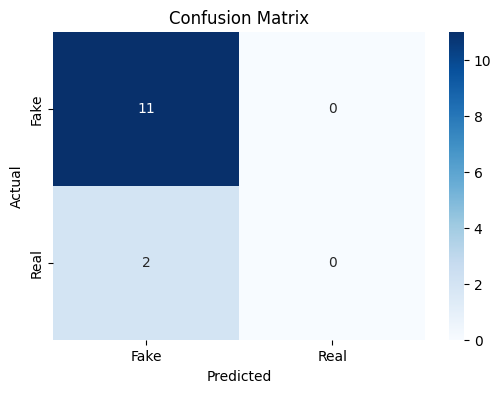

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       0.00      0.00      0.00         2

    accuracy                           0.85        13
   macro avg       0.42      0.50      0.46        13
weighted avg       0.72      0.85      0.78        13



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#BILSTM


In [ ]:
import librosa
import numpy as np

# Function to extract MFCC features from audio file
def extract_mfcc(audio_path, n_mfcc=13):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T  # Transpose to have shape (time_steps, n_mfcc)

# Example usage
audio_path = '/content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/FAKE/trump-to-musk.wav'
mfcc_features = extract_mfcc(audio_path)


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels, transform=None):
        self.audio_paths = audio_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        label = self.labels[idx]

        # Extract features (MFCC)
        features = extract_mfcc(audio_path)

        # Apply transform (optional)
        if self.transform:
            features = self.transform(features)

        # Convert to tensor
        features = torch.tensor(features, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        return features, label

# Example usage
audio_paths = ['/content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/FAKE/trump-to-musk.wav', '/content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/REAL/trump-original.wav']  # List of audio file paths
labels = [1, 0]  # 1 for real, 0 for fake

# Create Dataset and DataLoader
dataset = AudioDataset(audio_paths, labels)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


In [ ]:
import torch
import torch.nn as nn

class BiLSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTM_Model, self).__init__()

        # Define the BiLSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 for bidirectional

        # Activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass through LSTM
        lstm_out, (hn, cn) = self.lstm(x)

        # Use the last hidden state for classification
        out = self.fc(hn[-1])  # hn[-1] is the final hidden state

        # Apply sigmoid for binary classification (real or fake)
        out = self.sigmoid(out)
        return out


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels, transform=None):
        self.audio_paths = audio_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        label = self.labels[idx]

        # Extract features (MFCC)
        features = extract_mfcc(audio_path)

        # Apply transform (optional)
        if self.transform:
            features = self.transform(features)

        # Convert to tensor
        features = torch.tensor(features, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        return features, label

# Example usage
audio_paths = ['audio1.wav', 'audio2.wav']  # List of audio file paths
labels = [1, 0]  # 1 for real, 0 for fake

# Create Dataset and DataLoader
dataset = AudioDataset(audio_paths, labels)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import librosa
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# BiLSTM Model for Audio Classification
class BiLSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTM_Model, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        output = torch.sigmoid(output)
        return output

def audio_to_mfcc(audio_path, n_mfcc=13):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = torch.tensor(mfcc.T, dtype=torch.float32)
    return mfcc

class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels):
        self.audio_paths = audio_paths
        self.labels = labels

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        label = self.labels[idx]
        mfcc = audio_to_mfcc(audio_path)
        return mfcc, label

def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels, dtype=torch.float32).view(-1, 1)
    return inputs_padded, labels_tensor

# Example data
audio_paths = ['/content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/FAKE/trump-to-musk.wav',
               '/content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/REAL/trump-original.wav',
               '/content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/FAKE/trump-to-musk.wav']
labels = [0, 1, 0]

# Training setup
batch_size = 2
input_size = 13
hidden_size = 128
output_size = 1
learning_rate = 0.001
epochs = 5

# Create dataset and DataLoader
dataset = AudioDataset(audio_paths, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Initialize model, loss function, and optimizer
model = BiLSTM_Model(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_labels = []
    epoch_preds = []

    for inputs, labels in dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Store predictions and labels for metrics
        predictions = (outputs.detach().cpu().numpy() > 0.5).astype(int)
        labels_np = labels.cpu().numpy()

        epoch_labels.extend(labels_np.flatten())
        epoch_preds.extend(predictions.flatten())

    # Calculate metrics
    accuracy = accuracy_score(epoch_labels, epoch_preds)
    precision = precision_score(epoch_labels, epoch_preds)
    recall = recall_score(epoch_labels, epoch_preds)
    f1 = f1_score(epoch_labels, epoch_preds)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}')
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Epoch [1/5], Loss: 0.6896
Accuracy: 0.3333, Precision: 0.3333, Recall: 1.0000, F1 Score: 0.5000
Epoch [2/5], Loss: 0.6354
Accuracy: 0.6667, Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667
Epoch [3/5], Loss: 0.5290
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [4/5], Loss: 0.5238
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch [5/5], Loss: 0.5105
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


#GAN

In [ ]:
# Install necessary libraries
!pip install librosa numpy matplotlib torch torchvision
!pip install torchaudio

import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from PIL import Image


fake audio


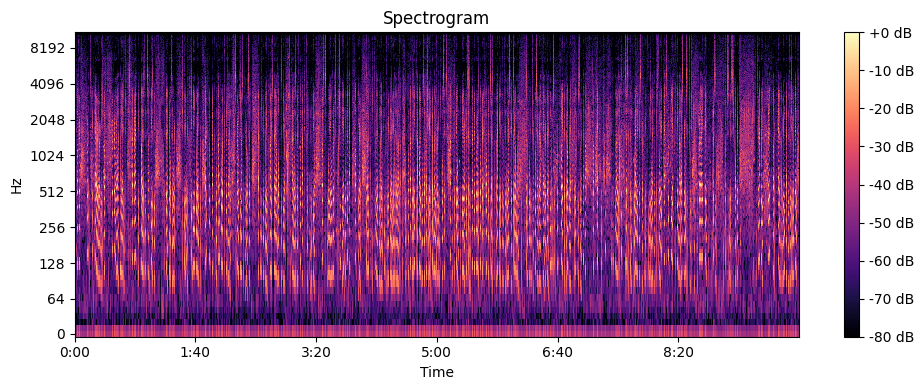

In [ ]:
# Function to convert audio to spectrogram
def audio_to_spectrogram(audio_path, n_fft=2048, hop_length=512):
    y, sr = librosa.load(audio_path)
    spectrogram = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
    return spectrogram_db

# Visualize the spectrogram
def show_spectrogram(spectrogram):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.tight_layout()
    plt.show()

# Example usage
spectrogram = audio_to_spectrogram('/content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/FAKE/trump-to-musk.wav')
show_spectrogram(spectrogram)


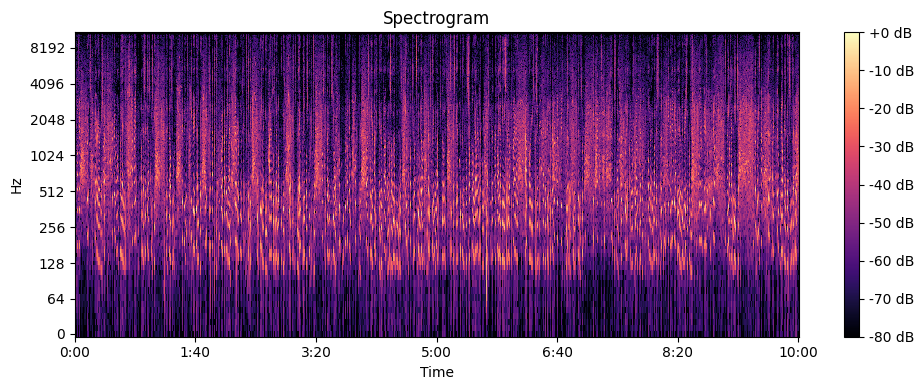

In [ ]:
# Function to convert audio to spectrogram
def audio_to_spectrogram(audio_path, n_fft=2048, hop_length=512):
    y, sr = librosa.load(audio_path)
    spectrogram = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
    return spectrogram_db

# Visualize the spectrogram
def show_spectrogram(spectrogram):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.tight_layout()
    plt.show()

# Example usage
spectrogram = audio_to_spectrogram('/content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/REAL/trump-original.wav')
show_spectrogram(spectrogram)


In [ ]:
# Simple GAN model with Generator and Discriminator

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize models
generator = Generator()
discriminator = Discriminator()

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)


In [ ]:
!pip install nn

  Preparing metadata (setup.py) ... done
  Created wheel for nn: filename=nn-0.1.1-py3-none-any.whl size=5705 sha256=4c6c7a815f4baa4281a0b1565d7e8aa4d0be0d6603142538053f5c65d2d480bc
  Stored in directory: /root/.cache/pip/wheels/60/62/98/7126b3684829be2701b0f07444922e84b3304646574a159431
Successfully built nn


In [ ]:
!pip install torch

import torch
import torch.nn as nn # Import nn from torch

# Training loop
epochs = 10000
batch_size = 32  # Define batch_size here or before the loop

for epoch in range(epochs):
    # Training Discriminator
    optimizer_D.zero_grad()

    # Train on real samples
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    # Generate fake samples
    noise = torch.randn(batch_size, 100)
    fake_images = generator(noise)

In [ ]:

import librosa
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Convert audio file to spectrogram
def audio_to_spectrogram(audio_path):
    y, sr = librosa.load(audio_path)
    spectrogram = librosa.feature.melspectrogram(y, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram_db

# Convert the spectrogram to tensor
def preprocess_audio(audio_path):
    spectrogram = audio_to_spectrogram(audio_path)
    spectrogram = np.expand_dims(spectrogram, axis=0)
    return torch.tensor(spectrogram, dtype=torch.float32).to(device)


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)


In [ ]:
def train_gan(epochs, batch_size):
    for epoch in range(epochs):
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Training the Discriminator on real spectrograms
        real_data = torch.randn(batch_size, 784).to(device)  # Replace with actual spectrogram data
        outputs = discriminator(real_data)
        d_loss_real = criterion(outputs, real_labels)

        # Training the Discriminator on fake data generated by Generator
        z = torch.randn(batch_size, 100).to(device)
        fake_data = generator(z)
        outputs = discriminator(fake_data.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        # Discriminator Backward and Optimize
        d_loss = d_loss_real + d_loss_fake
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Training the Generator
        outputs = discriminator(fake_data)
        g_loss = criterion(outputs, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

train_gan(epochs=5000, batch_size=32)


Epoch [0/5000], d_loss: 1.3516731262207031, g_loss: 0.6770097017288208
Epoch [100/5000], d_loss: 0.8944894075393677, g_loss: 2.4131875038146973
Epoch [200/5000], d_loss: 0.493561327457428, g_loss: 2.266263484954834
Epoch [300/5000], d_loss: 1.0598117113113403, g_loss: 3.436044931411743
Epoch [400/5000], d_loss: 0.0937814712524414, g_loss: 4.851170539855957
Epoch [500/5000], d_loss: 0.132233127951622, g_loss: 6.228001594543457
Epoch [600/5000], d_loss: 0.08475509285926819, g_loss: 4.465531826019287
Epoch [700/5000], d_loss: 0.03604826331138611, g_loss: 5.5875067710876465
Epoch [800/5000], d_loss: 0.026552848517894745, g_loss: 4.241218566894531
Epoch [900/5000], d_loss: 0.11794188618659973, g_loss: 4.365058422088623
Epoch [1000/5000], d_loss: 0.19210296869277954, g_loss: 10.052709579467773
Epoch [1100/5000], d_loss: 0.12346813827753067, g_loss: 7.904480457305908
Epoch [1200/5000], d_loss: 0.048156969249248505, g_loss: 6.404187202453613
Epoch [1300/5000], d_loss: 0.03825162351131439, g_lo

In [ ]:
!pip install librosa
import librosa
import librosa.display
import numpy as np
import torch
import torch.nn as nn

# Convert audio file to spectrogram
def audio_to_spectrogram(audio_path):
    y, sr = librosa.load(audio_path)
    # The melspectrogram function expects keyword arguments only
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram_db

# Convert the spectrogram to tensor
def preprocess_audio(audio_path):
    spectrogram = audio_to_spectrogram(audio_path)
    spectrogram = np.expand_dims(spectrogram, axis=0)
    return torch.tensor(spectrogram, dtype=torch.float32) #.to(device)

In [ ]:
!pip install librosa
import librosa
import librosa.display
import numpy as np
import torch
import torch.nn as nn

# Convert audio file to spectrogram
def audio_to_spectrogram(audio_path):
    y, sr = librosa.load(audio_path)
    # The melspectrogram function expects keyword arguments only
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram_db

# Convert the spectrogram to tensor
def preprocess_audio(audio_path):
    spectrogram = audio_to_spectrogram(audio_path)
    spectrogram = np.expand_dims(spectrogram, axis=0)
    return torch.tensor(spectrogram, dtype=torch.float32) #.to(device)

In [ ]:
from torchvision.transforms import Resize
import torch.nn.functional as F

def preprocess_audio(audio_path, target_shape=(28, 28)):
    # Convert audio to spectrogram
    spectrogram = audio_to_spectrogram(audio_path)

    # Convert to a tensor and add extra dimensions if needed
    spectrogram = torch.tensor(spectrogram, dtype=torch.float32)

    # Resize or pad the spectrogram to (28, 28) to match Discriminator's input
    spectrogram_resized = F.interpolate(spectrogram.unsqueeze(0).unsqueeze(0), size=target_shape, mode='bilinear')
    return spectrogram_resized.view(-1, 784).to(device)  # Flatten to match Discriminator's input


In [ ]:
def classify_audio(audio_path):
    # Convert audio to spectrogram and reshape for Discriminator
    spectrogram = preprocess_audio(audio_path)  # Already resized to (28, 28) in the updated function

    # Pass through Discriminator
    with torch.no_grad():
        output = discriminator(spectrogram)
        prediction = "Real" if output.item() > 0.5 else "Fake"

    print(f"The audio is classified as: {prediction}")

# Test with an audio file
classify_audio('/content/drive/My Drive/ProfElective_GenAI/Datasets/Audio_Dataset/KAGGLE/AUDIO/REAL/trump-original.wav')


The audio is classified as: Real
